In [1]:
# import libraries
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in data
df = pd.read_csv('monthly-beer-production-in-austr.csv')
df.head()

,Month,Monthly beer production in Australia
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [3]:
# checking for null values
df.isna().sum()

Month                                   0
Monthly beer production in Australia    0
dtype: int64

In [4]:
df['Month'] = df['Month'].apply(lambda x: dt(int(x[:4]),int(x[5:]),1))
df_ts = df.set_index('Month')
df_ts.head()

,Monthly beer production in Australia
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


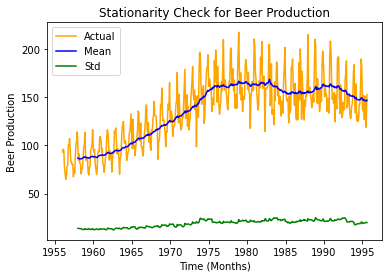

The test statistic is -2.283
The p-value is 0.178
The respective signifiance levels are:
1%    -3.444709
5%    -2.867871
10%   -2.570142
dtype: float64


In [5]:
# checking for stationarity using rolling statistics
def stationarity_test(time_series_data):
    
    # obtaining mean and standard deviation values 
    rolling_mean = time_series_data.rolling(window=25).mean()
    rolling_std = time_series_data.rolling(window=25).std()
    
    # plotting statistics
    plt.plot(time_series_data,color='orange',label='Actual Data')
    plt.plot(rolling_mean,color='blue',label='Mean')
    plt.plot(rolling_std,color='green',label='Standard Deviation')
    plt.legend(['Actual','Mean','Std'])
    
    plt.title('Stationarity Check for Beer Production')
    plt.xlabel('Time (Months)')
    plt.ylabel('Beer Production')
    plt.show()
    
    # Peforming Dickey-Fuller Test
    adfuller_test = adfuller(time_series_data,autolag = 'AIC')
    print('The test statistic is %.3f' % adfuller_test[0])
    print('The p-value is %.3f' %adfuller_test[1])
    print('The respective signifiance levels are:')
    print(pd.Series(adfuller_test[4]))

stationarity_test(df_ts)

From our Augmented Dickey-Fuller test, we notice that the p-value does not satisfy any of the significance levels (1%, 5% and 10%). We go ahead and stationarize our data using the differencing method. 

            Monthly beer production in Australia
Month                                           
1956-01-01                              4.534748
1956-02-01                              4.564348
1956-03-01                              4.555980
1956-04-01                              4.345103
1956-05-01                              4.261270


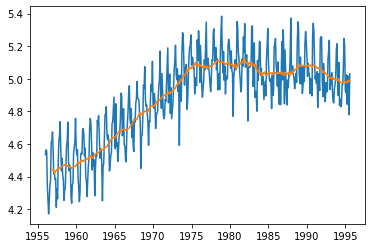

In [6]:
# apply log transformation
df_ts_log = np.log(df_ts)
print(df_ts_log.head())
movingAverage = df_ts_log.rolling(window=12).mean()
movingStd = df_ts_log.rolling(window=12).std()
plt.plot(df_ts_log)
plt.plot(movingAverage);

            Monthly beer production in Australia
Month                                           
1956-12-01                              0.231830
1957-01-01                              0.118994
1957-02-01                             -0.015558
1957-03-01                              0.001590
1957-04-01                             -0.041908


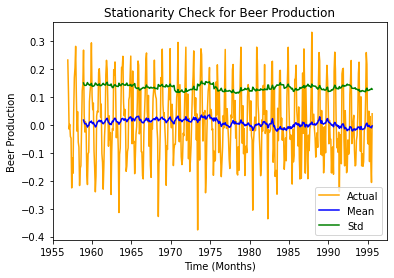

The test statistic is -3.433
The p-value is 0.010
The respective signifiance levels are:
1%    -3.444933
5%    -2.867970
10%   -2.570195
dtype: float64


In [7]:
# perform differencing using moving average
df_ts_log_diff = df_ts_log - movingAverage

# drop all NaN rows
df_ts_log_diff.dropna(axis = 0, inplace = True)
print(df_ts_log_diff.head())

# perform stationarity check again
stationarity_test(df_ts_log_diff)

Now our time series model is stationary. All the significance levels have been satisfied by our p-value.

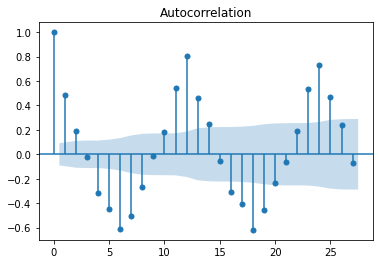

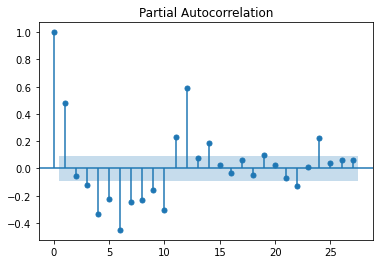

In [8]:
# perform time series forecasting
plot_acf(df_ts_log_diff)
plt.show()

plot_pacf(df_ts_log_diff)
plt.show()

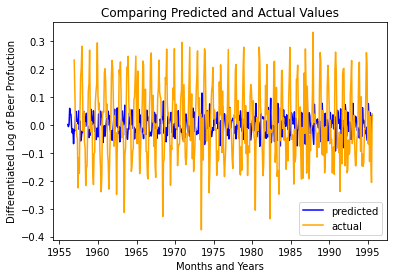

In [32]:
# creating ARIMA model
arima_model = ARIMA(df_ts_log, order = (0,1,1))
fitted_arima_model = arima_model.fit(disp=-1)

# comparing actual and predicted values in a plot
plt.plot(fitted_arima_model.fittedvalues, color = 'blue')
plt.plot(df_ts_log_diff,color = 'orange')
plt.legend(['predicted','actual'])
plt.title('Comparing Predicted and Actual Values')
plt.xlabel('Months and Years')
plt.ylabel('Differentiated Log of Beer Profuction')
plt.show()

# storing fitted arima model in variable
fitted_model_values = pd.Series(fitted_arima_model.fittedvalues, copy=True)

# plt.plot(fitted_model_values)
# plt.plot(df_ts_log_diff)

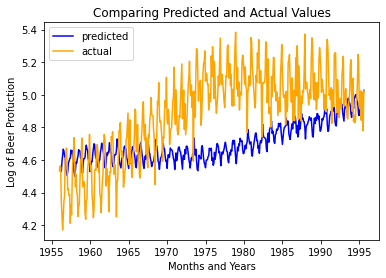

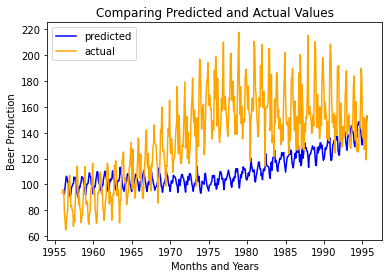

In [31]:
# undo differencing
fitted_model_values_cumsum = fitted_model_values.cumsum()
df_base_number = pd.Series(df_ts_log.iloc[0].values[0],index=fitted_model_values_cumsum.index)
updated_fitted_model_values = df_base_number.add(fitted_model_values_cumsum,fill_value = 0)

# comparing actual and predicted values in a plot
plt.plot(updated_fitted_model_values,color = 'blue')
plt.plot(df_ts_log,color = 'orange')
plt.legend(['predicted','actual'])
plt.title('Comparing Predicted and Actual Values')
plt.xlabel('Months and Years')
plt.ylabel('Log of Beer Profuction')
plt.show()

# undoing log transformation
predicted_values = np.exp(updated_fitted_model_values)

# comparing actual and predicted values in a plot
plt.plot(predicted_values,color = 'blue')
plt.plot(df_ts,color = 'orange')
plt.legend(['predicted','actual'])
plt.title('Comparing Predicted and Actual Values')
plt.xlabel('Months and Years')
plt.ylabel('Beer Profuction')
plt.show()

<AxesSubplot:xlabel='Month'>

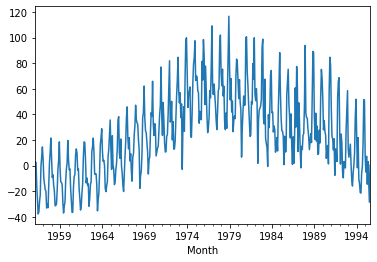

In [33]:
# checking for forecast error
actual_values = df_ts.values.copy()[1:]
predicted_values_copy = np.reshape(predicted_values.copy().values,[475,1])
error = actual_values - predicted_values_copy
error = pd.Series(error.ravel(),index=fitted_model_values.index)
error.plot()

**Lesson for today: Predictions will not always be accurate.**